# Topic Network 

This file builds a topic network. In the demo version, the a topic network is built over positive sentiments.

REQUIRED: Python 3.9.

In [13]:

num = "1" # "-1", "0"
t = 'pos' # "neg", "neutr"
full = 'Positive' # 'Negative', 'Neutral'

read_file_path = f'../data/sentiments/Gab/sentiment_{num}.txt'
seed = 'nvidia'
write_model_path = f'gab_senti_{t}.model'
write_pickle_path = f'gab_senti_{t}.pickle'
plot_title = f'Word Frequency in {full} Gab Posts mentioning NVIDIA'
desc = f'{full} Gabs'



In [14]:
from gensim.models import Word2Vec
from collections import Counter
import pandas as pd
import warnings
import logging #monitor gensim (Word2Vec)
import pickle
import time #Check runtime execution
import re #For preprocessing

import math
import pickle
from typing import List, Dict

import matplotlib.pyplot as plt
import networkx as nx
from gensim.models import Word2Vec
from networkx.algorithms.community import greedy_modularity_communities

# download spaCy model for American English
import spacy 
import en_core_web_sm

nlp = en_core_web_sm.load()

# opening the file in read mode
my_file = open(read_file_path, "r", encoding='utf-8') #Path of file that contains collected data you want to read
  
# reading the file
data = my_file.read()
  
# replacing end of line('/n') with ' ' and
# splitting the text it further when '.' is seen.
tweets = data.replace('\n', ' ').split(".")

#remove NaN from list (If applicable)
tokens = [x for x in tweets if str(x) != 'nan']

# remove non-english tweets

    
print(f"Number of total tweets: {len(tokens)}")

def tokenize_spacy(s, nlp):
    # To lowercase
    s = s.lower()
    # Creating a doc with spaCy
    doc = nlp(s)
    tokenized_sent = [] # Empty array
    flag = False
    
    #print("Initial sentence: [", doc, "]")
    
    for token in doc:
        #print("token: ", token)
        #print(flag)
        flag = False
        
        if not token.is_stop == True and not token.like_num and not token.is_punct:
            if str(token) != 'rt' and str(token) != 'amp' and 'http://' not in str(token) and 'https://' not in str(token) and not token.is_space and len(str(token))>=3 and str(token) !='user' and str(token) !='follow':
                    
                for c in token.text: 
                    if not (c.isalpha() or c in "@#.!;:*&$%^-+<>1234567890"):
                    #print(c)
                        temp_tok = str(token.text)
                        #print(temp_tok)
                        #token_new = temp_tok.substring(0, temp_tok.index(c))
                        x = temp_tok.index(c)
                        token_new = temp_tok[:x]
                        #print("new token ", token_new)
                        tokenized_sent.append(token_new)
                        flag = True
                        break
        
        
                if flag is True:
                    continue
                
                else:
                    tokenized_sent.append(token.lemma_)
                    #print(token.lemma_)
                    #tokenized_sent = tokenized_sent + " " + token.lemma_
                    #print(tokenized_sent)

    print(tokenized_sent)                
    return tokenized_sent

Number of total tweets: 1604


## Defining Seed Term & Using Word2Vec

['lust', 'blood', 'treasurefactor', 'federal', 'reserve', 'decision', 'cut', 'interest', 'rate', 'year', 'escalate', 'tension', 'iran', 'israel', 'semiconductor', 'stock', 'like', 'nvidia', 'nasdaq', 'nvda', 'super', 'micro', 'computer', 'nasdaq', 'smci', 'experience', 'loss', 'sustained', 'gain', 'contribute', 'unease']
['accord', 'diplomat', 'richard', 'haass', 'despite', 'setback', 'tough', 'time', 'market', 'far']
[]
['com', 'investor', 'brace', 'bad', 'period', 'ww2', 'says', 'diplomat', 'overvalue', 'property', 'use', 'collateral', 'loan', 'know', 'politic', 'head', 'insider', 'trading', 'info', 'like', 'pelosi', 'example', 'knowledge', 'deal', 'government', 'nvidia']
['billionaire', 'use', 'loan', 'money', 'long', 'profit', 'exceed', 'total', 'interest', 'loan']
['win', 'game']
['april', '2024gnome', 'mutter']
['bring', 'explicit', 'sync', 'well', 'nvidia', 'hybrid', 'gpu', 'acceleration']
['phoronix']
['com', 'news', 'gnome', 'mutter-46']
['releasedis', 'bubble', 'bursting', 'w

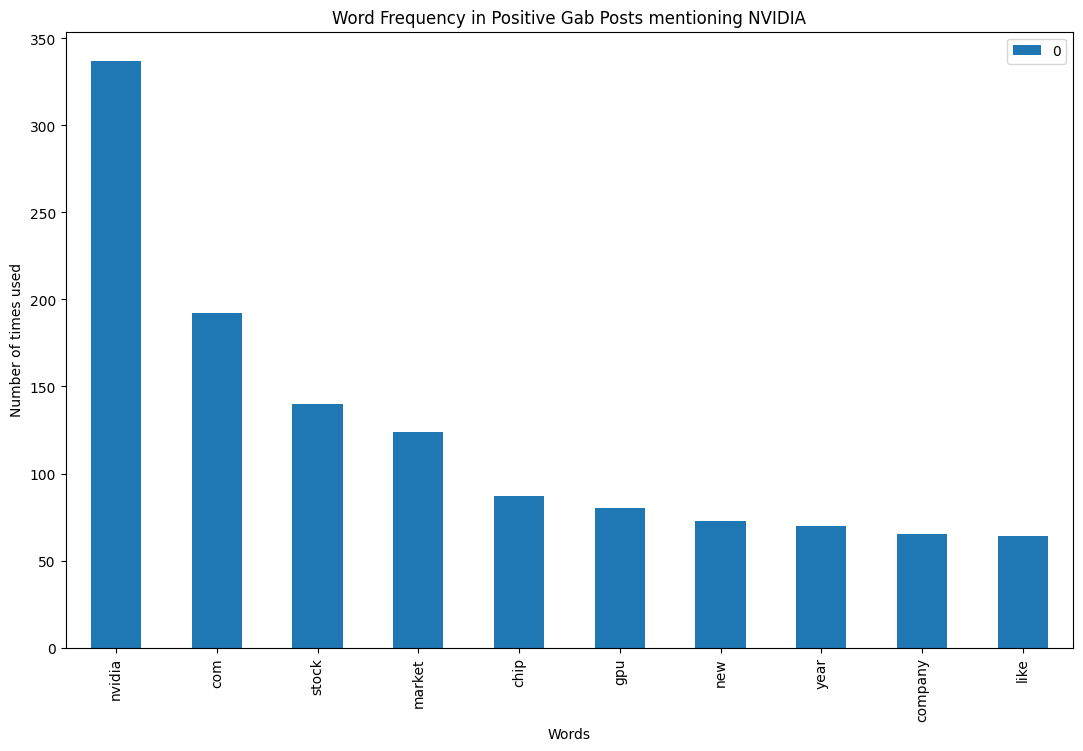

In [15]:
sentences = []
temp_list = []

for tok in tokens:
    #print("tok: ", tok)
    temp_list = tokenize_spacy(tok, nlp)
    sentences.append(temp_list)
    temp_list = [] # Making it empty for next round of tokenizing
len(sentences)
# Create Word2Vec diagram
model = Word2Vec( 
    sentences, 
    min_count = 1, 
    vector_size = 100, 
    workers = 4, 
    window = 10, 
    sg = 1
)
# Cosine Similarities
says = model.wv.most_similar(positive = [seed]) #Substitute word that you want as seed or center term of topic network
print(*says, sep = "\n")
# Getting the most frequent words
# flatten 2-d list of vectors into 1-d
words = [token for s in sentences for token in s]
freq = dict(Counter(words))

unique_words = dict(sorted(freq.items(), key = lambda x: x[1:], reverse = True))
print(list(unique_words.items())[0:10])
df_unique_words = pd.DataFrame.from_dict(unique_words, orient='index')
#Plotting most frequent words in a bar chart
df_unique_words.iloc[0:10].plot(kind='bar', title=plot_title, 
             ylabel='Number of times used', xlabel='Words', figsize=(13, 8))

plt.savefig(f'{t}_word_freq.png')
#df_unique_words.xlabel('Words', horizontalalignment='right', x=1.0)
#Dumps the Word2Vec Model & Unique Words into object files

SEED_WORDS = [seed] #Same word as before
NUM_HOPS = 2

#Below, put paths where you want to save .model & .pickle files - you can give any name for these files
with open((write_model_path), 'wb') as f1, open((write_pickle_path), 'wb') as f2:
    pickle.dump(model, f1)
    pickle.dump(unique_words, f2)
import math
import pickle
from typing import List, Dict

# 3rd-Party
import matplotlib.pyplot as plt
import networkx as nx
from gensim.models import Word2Vec
from networkx.algorithms.community import greedy_modularity_communities
# Initialize constants for the egonet graph (easily configurable)

SEED_WORDS = [seed] #Same word as before
NUM_HOPS = 2

# Load the necessary Word2Vec model
model = Word2Vec.load((write_model_path))  #Same path as where you saved .model file above

# Deserialize word frequency dictionary object
with open((write_pickle_path), 'rb') as fp: #Same path as where you saved .pickle file above
     wordfreqs = pickle.load(fp)
print(wordfreqs)

## Creating Topic Network

[+] Seed words that exist in the Word2Vec Vocabulary: nvidia
['week', 'nvidia', 'security', 'financial', 'sell', 'base', 'get', 'set', 'offer', 'come', 'time', 'japan', 'news', 'computing', 'watch', 'ceo', 'chip', 'future', 'world', 'geforce', 'main', 'go', 'game', 'graphic', 'replace', 'platform', 'server', 'card', 'enable', 'gaming', 'rtx', 'run', 'grace', 'developer', 'processing', 'use', 'chinese', 'infrastructure', 'jensen', 'bank', 'system', 'datum', 'new', 'hdmi', 'promise', 'human', 'hardware', 'solve', 'llm', 'need', 'mobile', 'end', 'well', 'machine', 'semiconductor', 'unveil', 'natural', 'generative', 'huang', 'lead', 'global', 'say', 'right', 'demand', 'want']


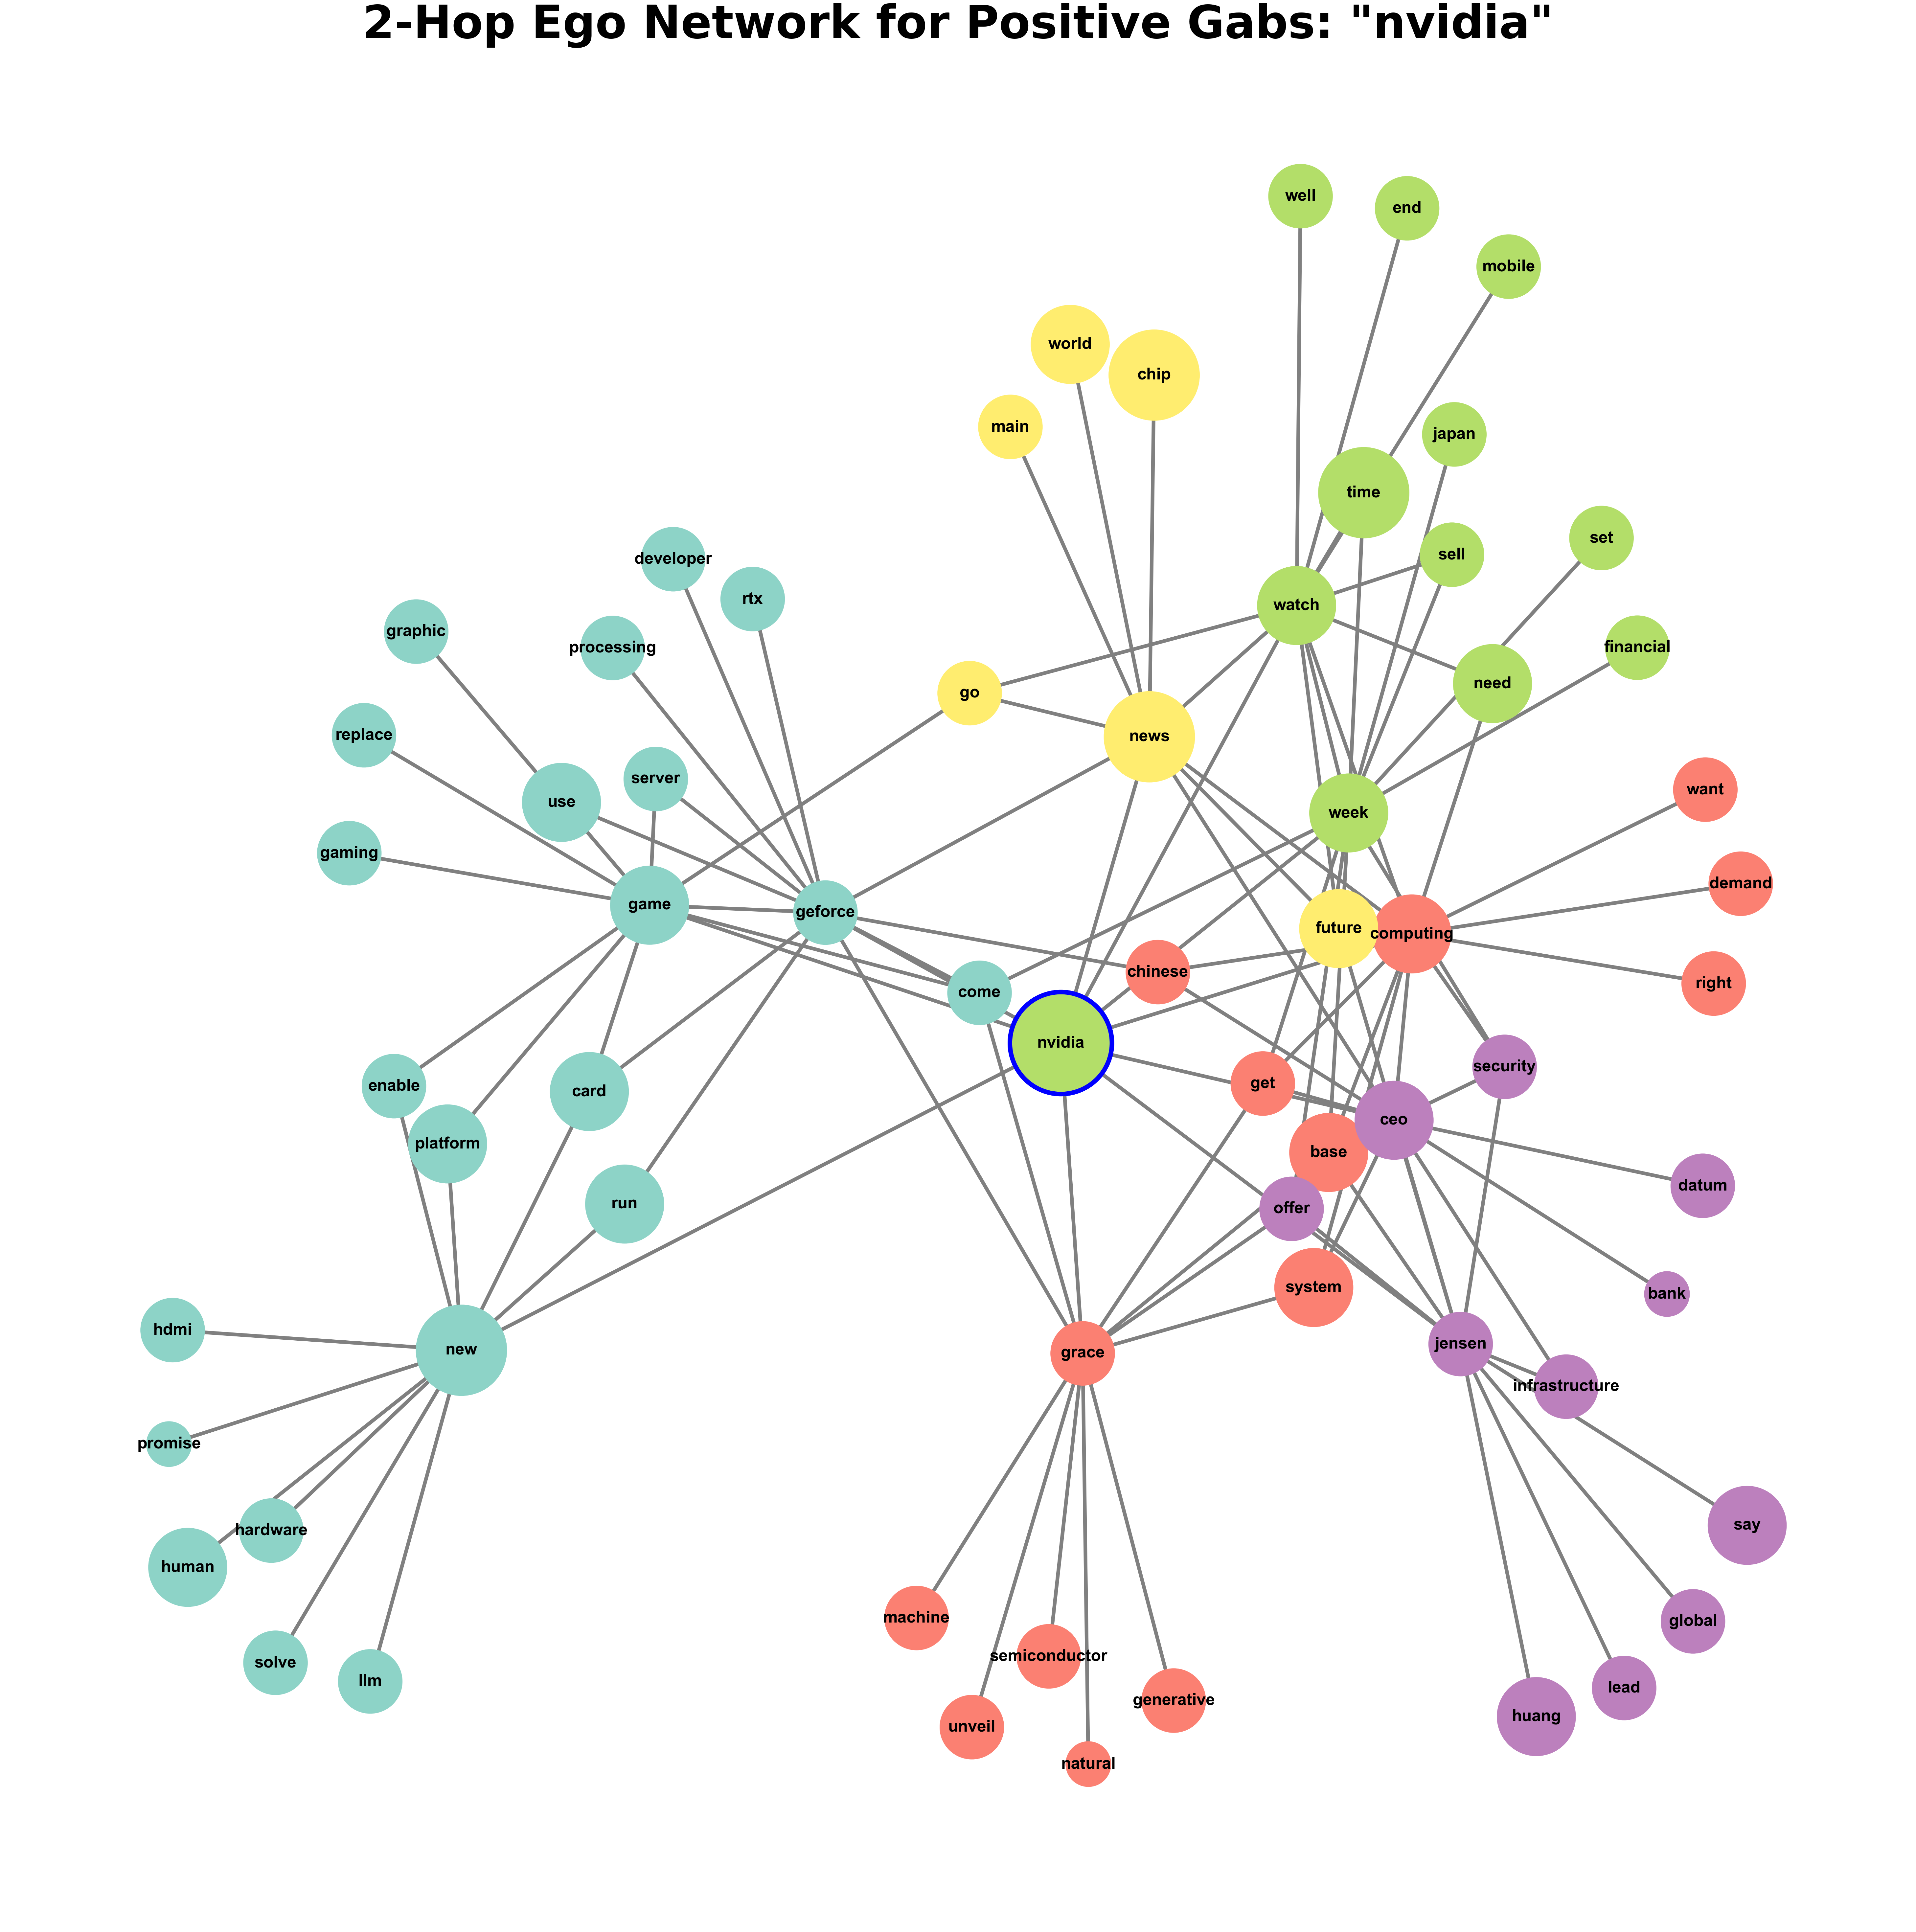

In [16]:
def create_n_hop_egonet(graph: nx.Graph(), w2v_model: Word2Vec(), seed_word: str, i: int = 0, num_hops: int = 2) -> nx.Graph():
 
    # Lambda functions to get a word vector's list of similar words, 
    # and the cosine similiarty between two word vectord
    get_similar_words = lambda word: [x[0] for x in w2v_model.wv.most_similar(positive = [word])]
    
    #get_similar_words = lambda word: [x[0] for x in w2v_model.wv.most_similar(positive = [word], negative = ['nationalist'])]
    get_closeness = lambda word_1, word_2: w2v_model.wv.similarity(word_1, word_2)    

    # Base case
    if i == num_hops: 
        return graph

    # Loop through each similar word to the seed word
    for similar_word in get_similar_words(seed_word):
        
        # Get the closeness value --> [0.0, 1.0]
        closeness = get_closeness(seed_word, similar_word)
        
        # Check if the distance is close enough (currently hardcoded at 0.4)
        if (1 - closeness) <= 0.4:
            
            # Add nodes and edges to graph
            graph.add_node(similar_word)
            graph.add_edge(seed_word, similar_word, weight = closeness)
        
        # Recurse on one of the similar words in the graph until i == num_hops
        create_n_hop_egonet(graph, w2v_model, similar_word, i + 1, num_hops)
# Check if seeds exist in word2vec model first (tweak if list is empty!)
def check_valid_seed_words(seed_words: List[str]) -> List[str]:

    # Filter list by using lambda function that checks trained Word2Vec model vocabulary
    return list(filter(lambda x: x in model.wv.index_to_key, seed_words))
# Generate ego network graph if seed words exist in list
seed_words = check_valid_seed_words(SEED_WORDS)
if seed_words == []:
    print("[!] No seed words exist in the Word2Vec Vocabulary! Try other words!")
else:
    print(f"[+] Seed words that exist in the Word2Vec Vocabulary: {','.join(seed_words)}")
    # Initialize empty graph, and append n_hop edges --> (seed_word, similar_word) 
    # for all seed words in the configured list
    graph = nx.Graph()
    for seed_word in seed_words:
        create_n_hop_egonet(graph, model, seed_word, 0, NUM_HOPS)

def get_egonet_graph_communities(graph: nx.Graph()) -> Dict[str, int]:

    # Sorting the community by length of largest communitites for all number of partitions
    communities = sorted(greedy_modularity_communities(graph), key = len, reverse = True)
  
    # Create a membership dictionary --> {word: partition #}
    memberships = {n: i for i, ns in enumerate(communities) for n in ns}
    return memberships
#print(node_list)
# Mathematical calculations to determine the sizes of nodes & their corresponding labels
subsetfreqs = {word: wordfreqs[word] for word in graph.nodes()}
totalfreq = sum(f for _, f in subsetfreqs.items())
logfreqs = dict([(w, int(math.log(f))*100) for (w,f) in subsetfreqs.items()])

wordpdfs = dict([(w, f/totalfreq) for (w,f) in subsetfreqs.items()])
wordsizes = dict([(w, int(p*10**5)) for (w,p) in wordpdfs.items()])

node_sizes = [v * 100 for v in logfreqs.values()]
# Create node / edge color and font sizes lists based on memberships
memberships = get_egonet_graph_communities(graph)
words = list(graph.nodes())

node_colors = [memberships[n] for n in graph.nodes()]
edge_colors = ['None' for i in range(0, len(words))]
font_sizes = [s / 100 for s in node_sizes] 

# Create colored border around seed nodes
for i in range(0, len(words)):
    for seed in seed_words:
        if words[i] == seed:    
            # Color is easily changeable
            edge_colors[i] = ('blue') 
# List of graph nodes before plotting
print(words)
# Make dimensions of plt plot
fig, ax = plt.subplots(figsize=(75, 75))

# Create egonet graph layout
pos = nx.layout.fruchterman_reingold_layout (
    graph, 
    dim = 2, 
    k = 50, 
    pos = nx.layout.kamada_kawai_layout(graph), 
    fixed = None, 
    iterations = 5000, 
    weight='weight', 
    scale = 25, 
    center = None
)

# Set title of picture and set various layouts
ax.set_title(
    f'{NUM_HOPS}-Hop Ego Network for {desc}: "{" ".join(SEED_WORDS)}"', 
    y = 1.0, pad = -14, 
    fontsize = 100, 
    fontname = "DejaVu Sans", 
    fontweight = 'bold', 
)

# Draw the egonet graph based on previously configured parameters
nx.draw(
    graph, 
    pos = pos, 
    ax = ax,
    with_labels = True, 
    node_color = node_colors, 
    node_size = node_sizes,
    font_size = 36,
    cmap = plt.cm.Set3,
    width = 8,
    font_weight = 'bold',
    linewidths = 10.0,  
    edge_color = 'grey',
    edgecolors = edge_colors,
    font_family = "Arial"
)

#print(" ".join(SEED_WORDS))

#Save graph as png and export gephi file
nx.write_gexf(graph, f'{" ".join(SEED_WORDS)}-topic.gexf') #Path to save gexf file
plt.savefig(f'{desc}_net{NUM_HOPS}hop_{" ".join(SEED_WORDS)}.png') #Path to save image

In [31]:
from gensim.models import Word2Vec

# Load your trained Word2Vec model
model = Word2Vec.load("nvidia.model")

# Compute cosine similarity between two words
word1 = "nvidia"
word2 = "moon"
similarity = model.wv.similarity(word1, word2)

print(f"Cosine similarity between {word1} and {word2} is {similarity}")

Cosine similarity between nvidia and moon is 0.9632893204689026


In [45]:
import numpy as np

# Load your trained Word2Vec model
model = Word2Vec.load("nvidia.model")

# Compute cosine similarity between two words
word1 = "nvidia"
word2 = "nvidia"
vec1 = model.wv.get_vector(word1, norm=True) if word1 in model.wv else np.zeros(model.vector_size)
vec2 = model.wv.get_vector(word2, norm=True) if word2 in model.wv else np.zeros(model.vector_size)
print(vec1)
print(vec2)
if word1 in model.wv and word2 in model.wv:
    print('in vocab')
    similarity = model.wv.similarity(word1, word2)
else:
    print('OOV')
    similarity = np.dot(model.wv.get_vector(word1, norm=True) if word1 in model.wv else np.zeros(model.vector_size),
                        model.wv.get_vector(word2, norm=True) if word2 in model.wv else np.zeros(model.vector_size))

print(f"Cosine similarity between {word1} and {word2} is {similarity}")

[ 0.00215059  0.07362086  0.02666346  0.06574485 -0.01120999 -0.17218369
  0.05496808  0.19798078 -0.06970866 -0.18082036 -0.0043598  -0.19782269
 -0.01341218  0.05891651 -0.06587041 -0.13074304  0.07504221 -0.13406798
 -0.07373058 -0.24179688  0.05210548 -0.02818482  0.07024575 -0.14371182
  0.05606237 -0.12124401 -0.07111072 -0.04473649 -0.07639367  0.05930956
  0.06829905  0.09122606  0.06885251 -0.16210842 -0.03075819  0.1126141
  0.10054009  0.09682209 -0.062566   -0.1977028   0.02037491 -0.07751811
 -0.04085577  0.06482206  0.07592516 -0.15282555 -0.07587395  0.05196422
  0.17341426  0.07647379 -0.02428102 -0.09142289  0.01111587  0.02069454
 -0.02481276  0.0626795  -0.00277849  0.00515101 -0.16162597  0.08128085
  0.1196005  -0.03356179  0.00628357  0.00281839 -0.13312852  0.1649474
 -0.05604503  0.11990795 -0.11996077  0.05993369  0.02531665  0.09537469
  0.09362742 -0.01971146  0.22903802  0.0241239   0.04227367  0.02407502
 -0.03528577 -0.00752094 -0.16512674  0.00926481 -0.1

In [64]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk


sia = SentimentIntensityAnalyzer()

text = 'why should i care about nvidia?'
text = '''
生成AI → NVIDIA → 半導体 → 日本の半導体企業......材料仕入れて、つくる。米国頼りのお家芸か、これぞ日本なのか。Nvidia expects next-gen Blackwell GPUs to be supply constrained https://t.co/JNoUIdD7QO@PhoHuu98182 Nvidia surpassed big names one after another@HoudiniFont @NikTekOfficial I dont mean necessarily the nvidia dlss, could be fsr or any equivalent. Just a 4k 60fps that doesnt look blurry as fuck@CNN Any Linux user will tell you: the Nvidia graphics card is the crappiest@mobymedia @nvidia That's excellent and really surprising.@mytechceoo @nvidia @ericzhu105 @aribk24 Microchips fly by air freightおはようございます！今日から3連休ですね！
Nvidiaの好決算を受け、米国市場はAI関連銘柄を中心に買いが先行し、3指数全て大幅な上昇を見せました。
DOW +1.18%
NASDAQ +2.96%🔥
S&amp;P500 +2.11%🔥
NASDAQとS&amp;P500は2%以上の高騰✅
セクター別では公益とネットワークなどのバリュー株が下げています⤵️ https://t.co/IezHYXn635@Borgtf @CedricGouallec @Cryptodelpueblo @nvidia La chart est sympa gros range qui n'a pas break encore$AMD catching possible windfall off NVidia the new mark leader of all sectors but more importantly the leading asset maker in chip manufacturing. "A rising tide lifts all boats" or so they say.  Stop below last consolidation. #spy #DJI #dow https://t.co/MKe7UDpdlTおはよう
NVIDIAやばすぎてびっくり🤣@paulbatistta @NVIDIAGeForceBR A sobreposição da minha NVidia parou de funcionar tem um tempo, sempre que tento ativar da erro, alguém sabe o motivo?So if I’ve got the economy straight, literally everybody is broke except NVIDIA and some hedge fund assholes?!?LISTEN NOW: Both the Dow and S&amp;P saw record closes today following Nvidia’s strong earnings report. Listen and follow the @CNBCOvertime podcast here: https://t.co/PhvVUfPR0h https://t.co/Wej1v70tGY@TechDeals_16 My Nvidia gains pay for my new gpus. It's nice.Nvidia Tops Meta Record With $277 Billion Surge in Value  https://t.co/NuMb5WyaWo#5Things: Euphoria surrounding Nvidia’s blistering rally spreads across markets, Federal Reserve officials warn against cutting rates too soon, and quant hedge funds in China are admitting to unprecedented failures. Here’s what’s moving markets. https://t.co/o6DgEkRP6qおはようございます。
本日は、天皇誕生日で休場ですが、昨夜のニューヨークは活況だったようで安心しました😮‍💨
NVIDIAショックは起こらなかったようでなによりですね👍 https://t.co/uqeDoicpqNNvidiaもAI需要が一通り終わったらまた下がるだろうし次の一手がないと利益上がらないだろうし売りどきがむずいね。後1年くらいはまだいけるかな。Appleもiphoneが売れてるだけで利益すごいけど何年も継続してるしやっぱ未来は誰もわからんね。分散投資がええ。@govt_corrupt Nvidia is worth more than our Country right now.昨夜、NVIDIAを寄成で買注文出してから寝て、起きたら本業の月給相当の含み益出ていてビックリ💦
NVIDIA株の勢いがすごいのか、自分の給料が安いのか😅
#NVIDIANvidia'nın hisseleri aslında bu hafta başında değer kaybetmişti, ancak şirket 4.Ç. kazanç beklentilerini aştıktan sonra büyük ölçüde geri döndü. Dün Nvidia, 4.Ç. için bir önceki yıla göre %769 artışla 12,3 milyar dolar net gelir bildirdi. Toplam gelir ise yapay zeka çiplerine https://t.co/rQJIykw3eW@Factschaser @fau1in @squawksquare Dlss 3.0 is not obviously better than 2.0, frame gen introduces input latency even tho nvidia advertised on reflex reducing latency, problem is it often crashed the driver. Or maybe this is how it is when your buying into bleeding edge tech that is always in rolling development🛎️ PRE-ORDER ALERT 🛎️
'''
sentiment = sia.polarity_scores(text)

print(sentiment)

{'neg': 0.059, 'neu': 0.839, 'pos': 0.102, 'compound': 0.9634}
